In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt

os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/lib/cuda'
os.environ["CUDA_VISIBLE_DEVICES"]="6"

In [2]:
import tensorflow as tf
from tensorflow import keras

print("GPU available:", len(tf.config.list_physical_devices('GPU')))

2023-05-28 20:52:37.273184: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-28 20:52:38.179434: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


GPU available: 1


2023-05-28 20:52:39.273359: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-28 20:52:39.313982: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-28 20:52:39.315827: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
from data_preprocessing import DataProcessor, Dataset
from model import OCCModel
from autoencoder import MLPAutoencoder
from var_autoencoder import MLPVarAutoencoder
from loss import WeightedMSE

In [4]:
PROJECT_PATH = '/raid/shumnov/music-style-performer/'

In [5]:
architecture = [((256, 128), (0, 0), (128, 256), (0, 0)), 
                ((256, 128, 128), (0.1, 0.1, 0.1), (128, 128, 256), (0.1, 0.1, 0.1)), 
                ((256, 256, 128), (0.4, 0.2, 0.1), (128, 256, 256), (0.1, 0.1, 0.1)),
                ((128, 64, 64), (0, 0, 0), (64, 64, 128), (0, 0, 0))]
noise = [0.02, 0.08, 0.2]
latent_dim = [64, 32]
absolute_velocities = [True, False]

In [6]:
def test(av, ld, n, arch, name, legw=1, checkpoint_id=None, epochs=10):
    print(name)
    
    dp = DataProcessor(
        notes_qty=64, 
        include_first_tone=False, 
        absolute_velocities=av)
    
    dset = Dataset(dp, 64)
    
    print('Loading dataset...')
    dset.load_dset(PROJECT_PATH + 'data/dset64.npy', 2000)
    print('Dataset loaded')
    
    autoencoder = MLPAutoencoder(
        input_size=dp.input_size,
        latent_dim=ld,
        noise=n,
        encoder_layers=arch[0],
        encoder_dropout=arch[1],
        decoder_layers=arch[2],
        decoder_dropout=arch[3])
    
    loss = WeightedMSE(
        vel_mask=dp.vel_mask, 
        leg_mask=dp.leg_mask, 
        first_last_mask=dp.first_last_mask, 
        vel_weight=1, 
        leg_weight=legw,
        first_last_weight=1)
    
    model = OCCModel(
        autoencoder=autoencoder,
        dataprocessor=dp,
        dist_weight=1, 
        vel_weight=1, 
        leg_weight=legw
    )
    model.compile(
        modelsdir=PROJECT_PATH+'traindata/ae/64',
        name=name, 
        optimizer=keras.optimizers.Adam(3e-5),
        loss=loss,
        ckpt_epochs=1
    )
    model.summary()
    
    if checkpoint_id is not None:
        model.restore(checkpoint_id)
    
    print('Start training...')
    model.fit(dset, epochs, 3)

In [ ]:
for ld in range(len(latent_dim)):
    for av in range(len(absolute_velocities)):
        for n in range(len(noise)):
            for a in range(len(architecture)):
                test(absolute_velocities[av], latent_dim[ld], noise[n], architecture[a], f'{ld}{av}{n}{a}')

0023
Loading dataset...


/raid/shumnov/anaconda3/envs/tf/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:411: RuntimeWarning: Mean of empty slice.
  loc = data.mean()
/raid/shumnov/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/raid/shumnov/anaconda3/envs/tf/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:416: RuntimeWarning: Mean of empty slice.
  scale = np.sqrt(((data - loc)**2).mean())


Dataset loaded


2023-05-28 20:53:20.434395: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-28 20:53:20.436280: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-28 20:53:20.437938: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Start training...
Epoch 1/40


2023-05-28 20:53:44.694846: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x21be3800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-28 20:53:44.694893: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Tesla V100-SXM3-32GB, Compute Capability 7.0
2023-05-28 20:53:44.700687: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-28 20:53:44.933380: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-28 20:53:45.021054: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2023-05-28 20:53:45.071170: I ./tensorflow/compiler/jit/device_compiler.h:180] Com

82301/82301 - 277s - loss: 0.2516 - val_loss: 0.1991 - occ_accuracy: 0.2737 - 277s/epoch - 3ms/step
Epoch 2/40
82301/82301 - 273s - loss: 0.1964 - val_loss: 0.1834 - occ_accuracy: 0.2752 - 273s/epoch - 3ms/step
Epoch 3/40
82301/82301 - 274s - loss: 0.1878 - val_loss: 0.1765 - occ_accuracy: 0.2755 - 274s/epoch - 3ms/step
Epoch 4/40
82301/82301 - 277s - loss: 0.1811 - val_loss: 0.1683 - occ_accuracy: 0.2760 - 277s/epoch - 3ms/step
Epoch 5/40
82301/82301 - 275s - loss: 0.1770 - val_loss: 0.1666 - occ_accuracy: 0.2771 - 275s/epoch - 3ms/step
Epoch 6/40
82301/82301 - 276s - loss: 0.1751 - val_loss: 0.1635 - occ_accuracy: 0.2763 - 276s/epoch - 3ms/step
Epoch 7/40
82301/82301 - 276s - loss: 0.1731 - val_loss: 0.1626 - occ_accuracy: 0.2758 - 276s/epoch - 3ms/step
Epoch 8/40
82301/82301 - 277s - loss: 0.1714 - val_loss: 0.1600 - occ_accuracy: 0.2746 - 277s/epoch - 3ms/step
Epoch 9/40
82301/82301 - 276s - loss: 0.1688 - val_loss: 0.1567 - occ_accuracy: 0.2745 - 276s/epoch - 3ms/step
Epoch 10/40


/raid/shumnov/music-style-performer/src/ml/discriminator/data_preprocessing.py:236: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(3, 2, figsize=(10, 10))


82301/82301 - 276s - loss: 0.1607 - val_loss: 0.1492 - occ_accuracy: 0.2741 - 276s/epoch - 3ms/step
Epoch 22/40
82301/82301 - 275s - loss: 0.1607 - val_loss: 0.1493 - occ_accuracy: 0.2741 - 275s/epoch - 3ms/step
Epoch 23/40
82301/82301 - 278s - loss: 0.1607 - val_loss: 0.1492 - occ_accuracy: 0.2741 - 278s/epoch - 3ms/step
Epoch 24/40
82301/82301 - 275s - loss: 0.1607 - val_loss: 0.1492 - occ_accuracy: 0.2741 - 275s/epoch - 3ms/step
Epoch 25/40
82301/82301 - 276s - loss: 0.1607 - val_loss: 0.1493 - occ_accuracy: 0.2740 - 276s/epoch - 3ms/step
Epoch 26/40
82301/82301 - 280s - loss: 0.1604 - val_loss: 0.1468 - occ_accuracy: 0.2733 - 280s/epoch - 3ms/step
Epoch 27/40
82301/82301 - 277s - loss: 0.1580 - val_loss: 0.1459 - occ_accuracy: 0.2737 - 277s/epoch - 3ms/step
Epoch 28/40
82301/82301 - 277s - loss: 0.1559 - val_loss: 0.1435 - occ_accuracy: 0.2717 - 277s/epoch - 3ms/step
Epoch 29/40
82301/82301 - 277s - loss: 0.1553 - val_loss: 0.1435 - occ_accuracy: 0.2715 - 277s/epoch - 3ms/step
Epoc

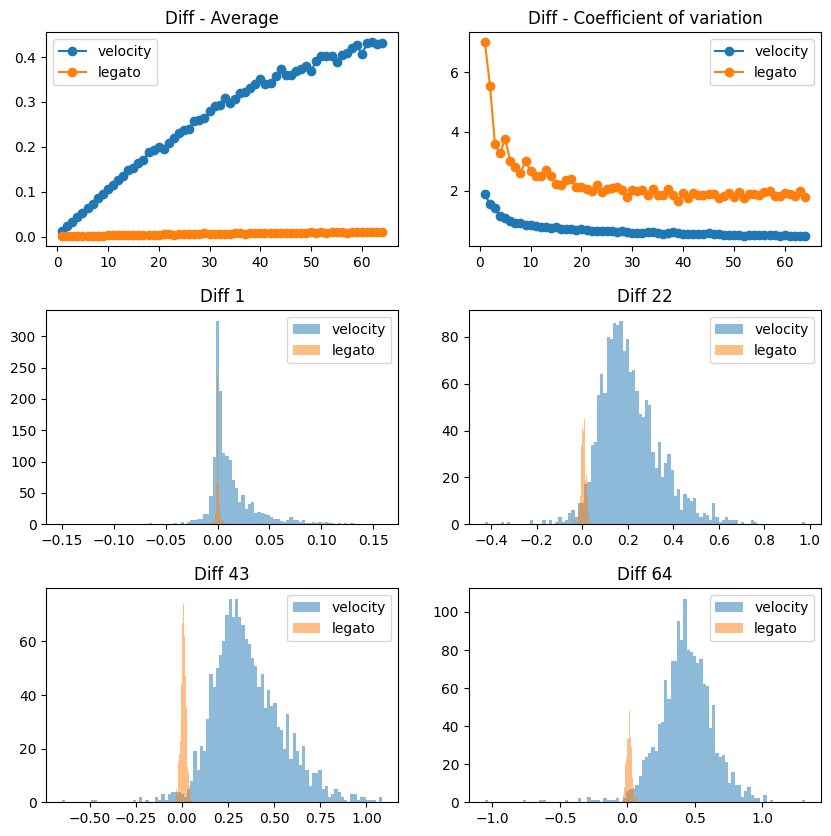

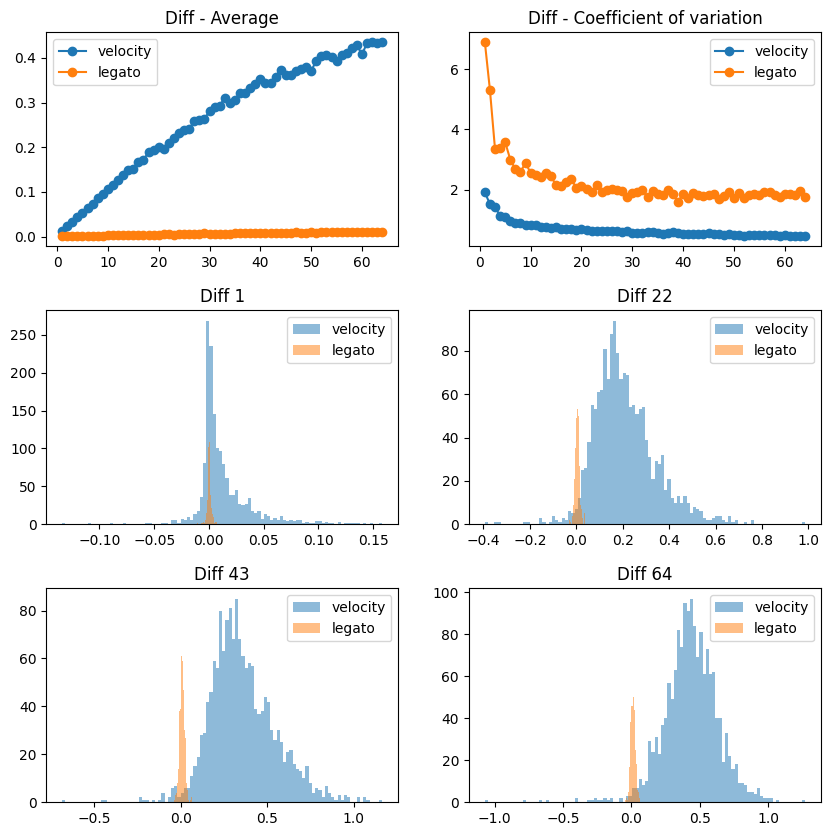

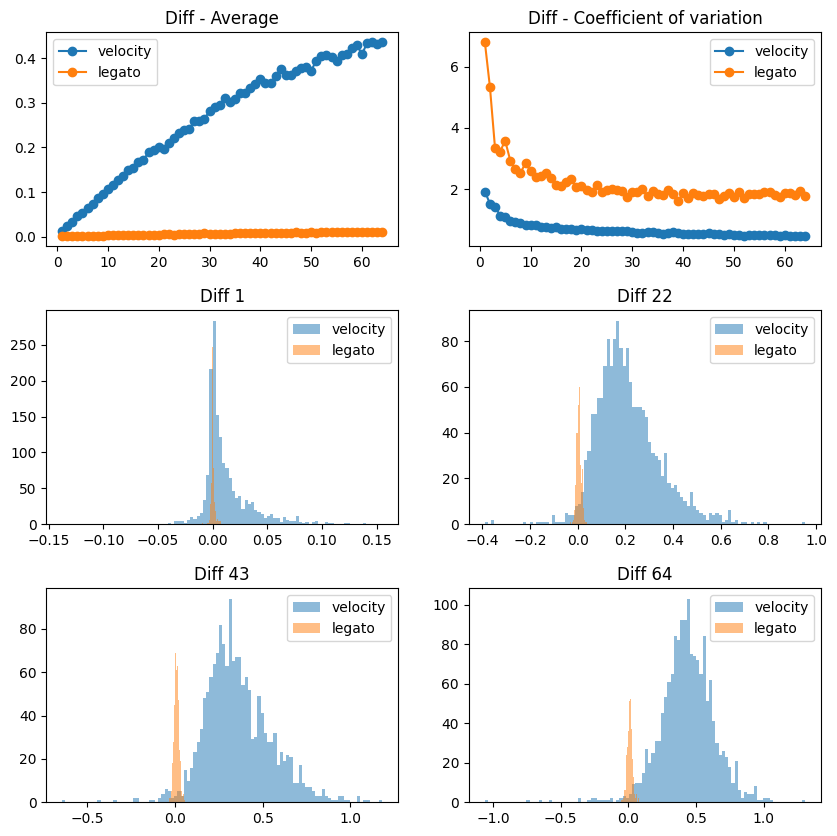

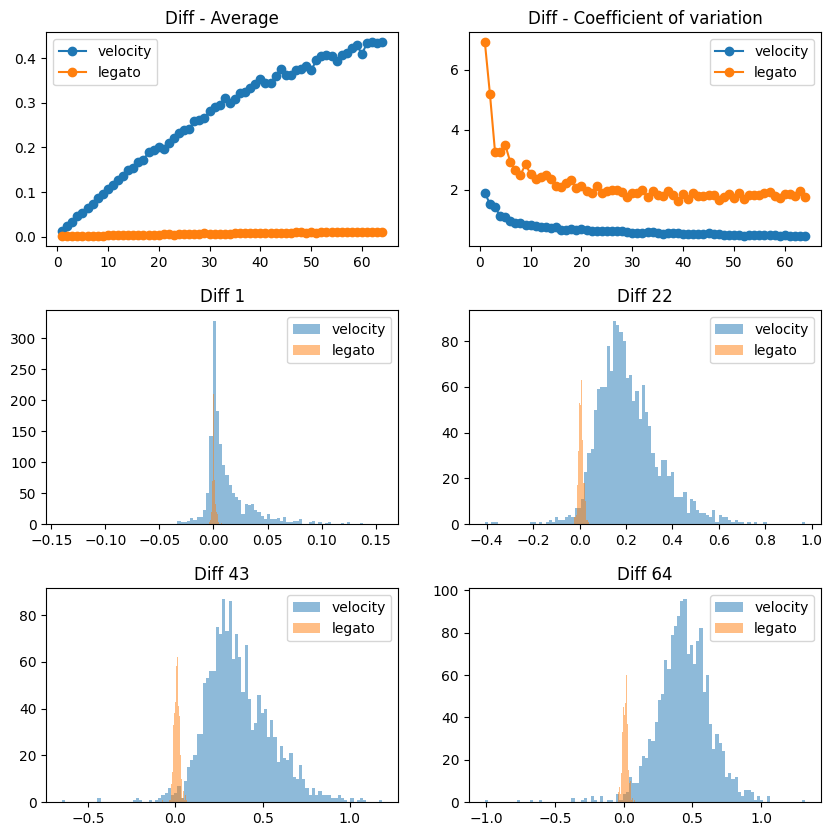

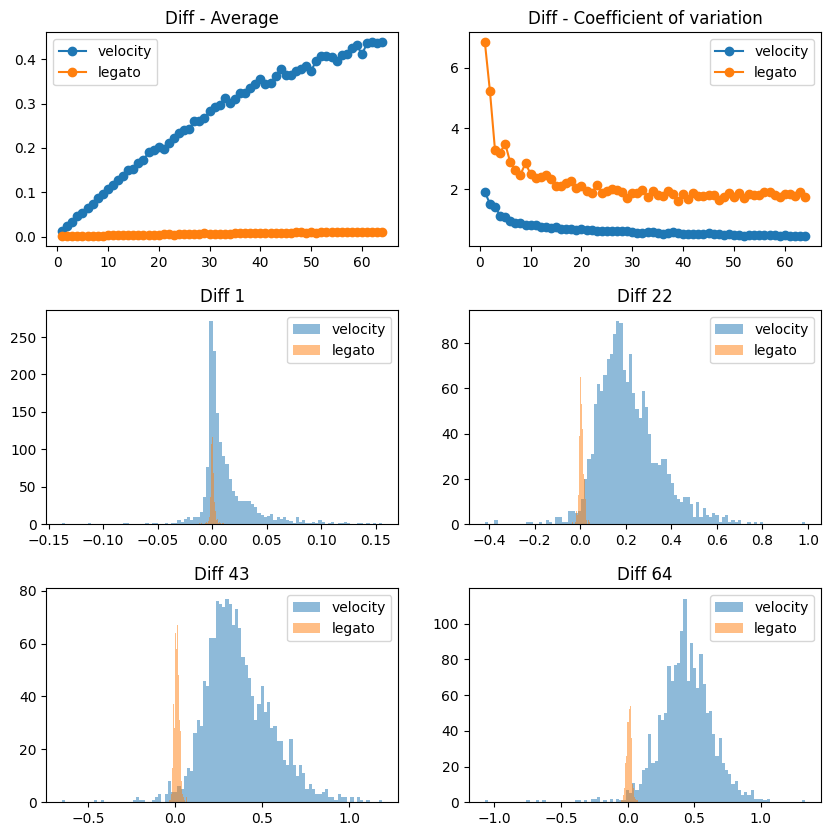

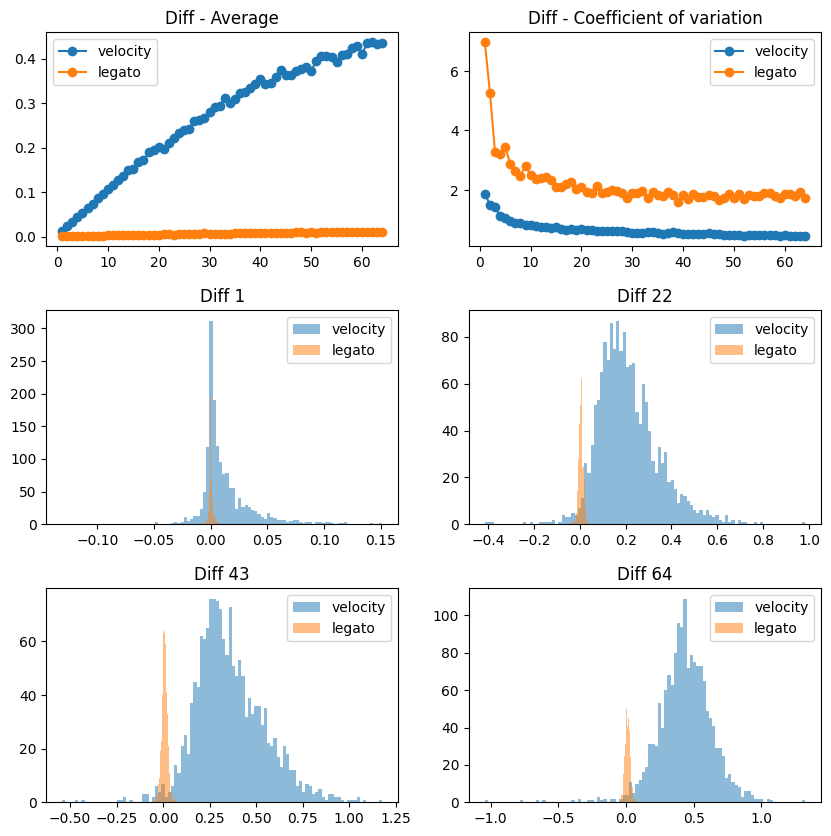

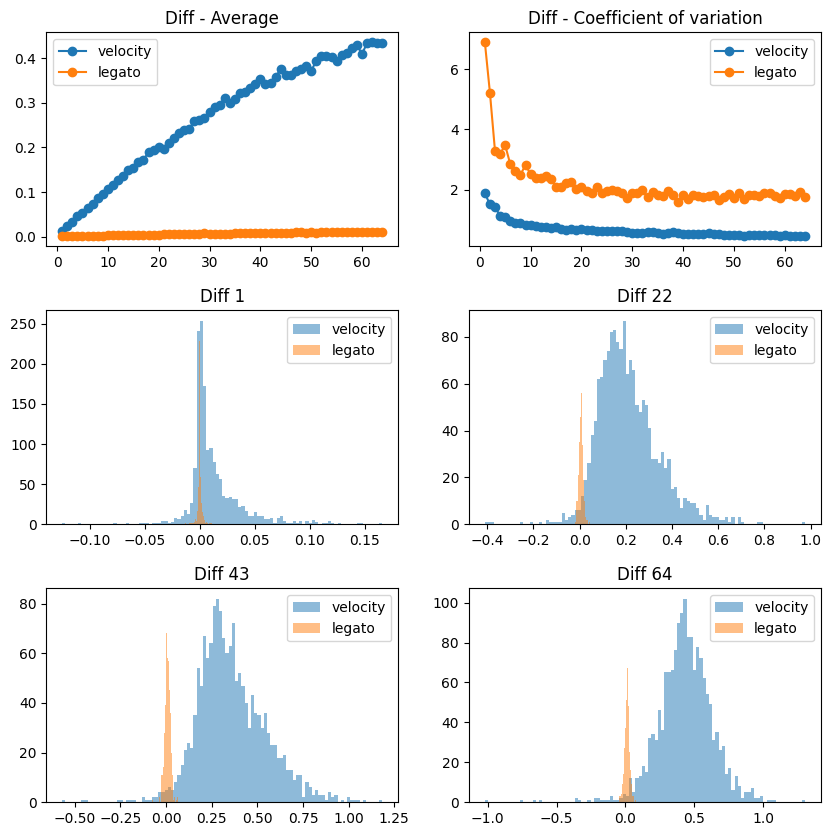

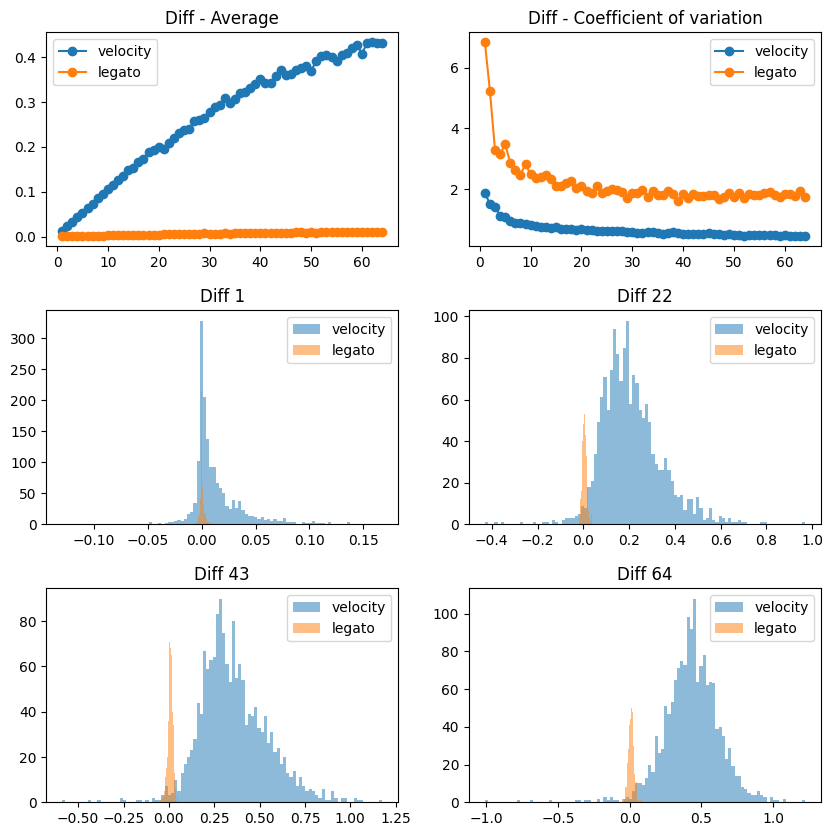

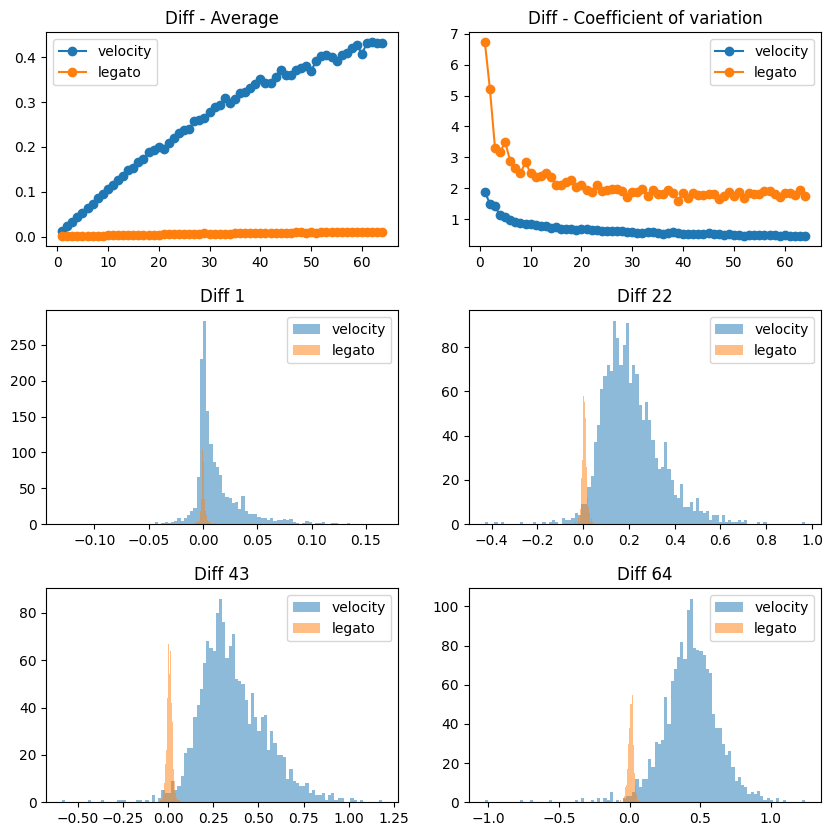

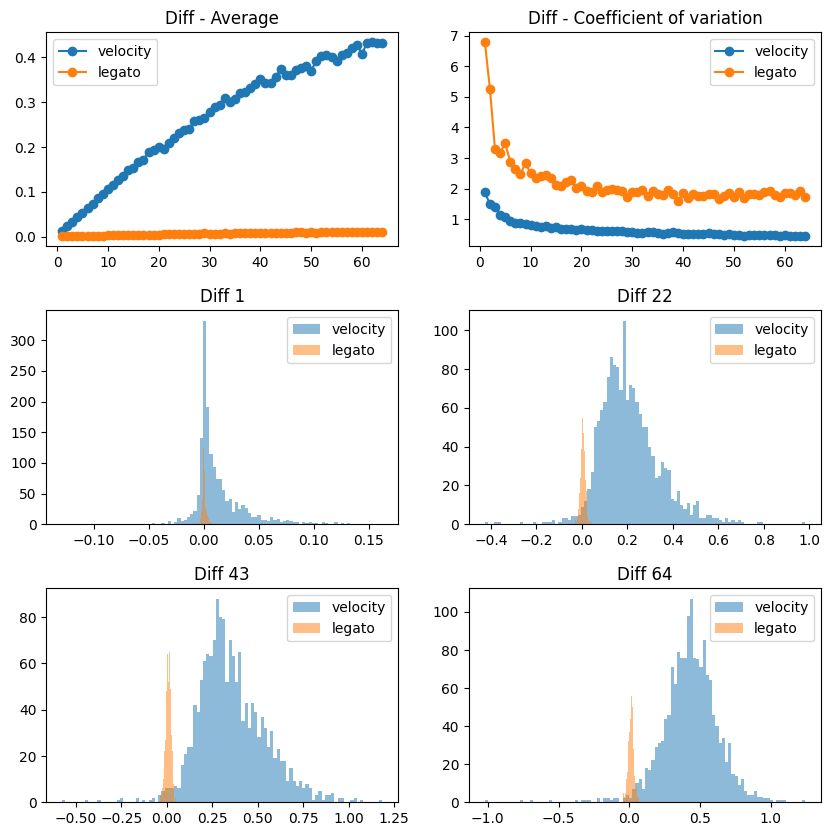

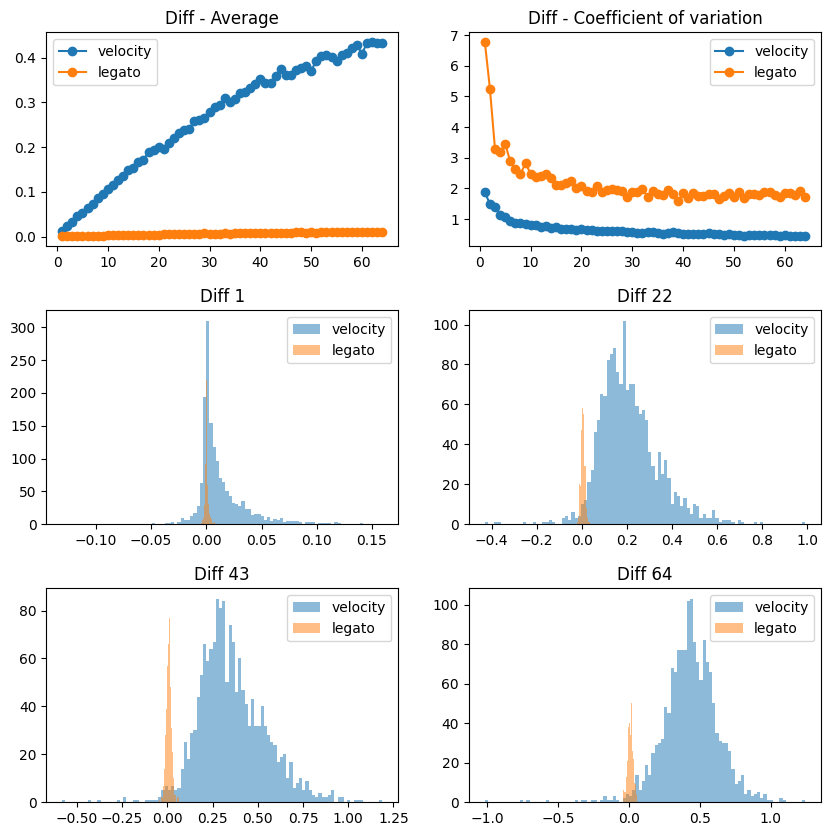

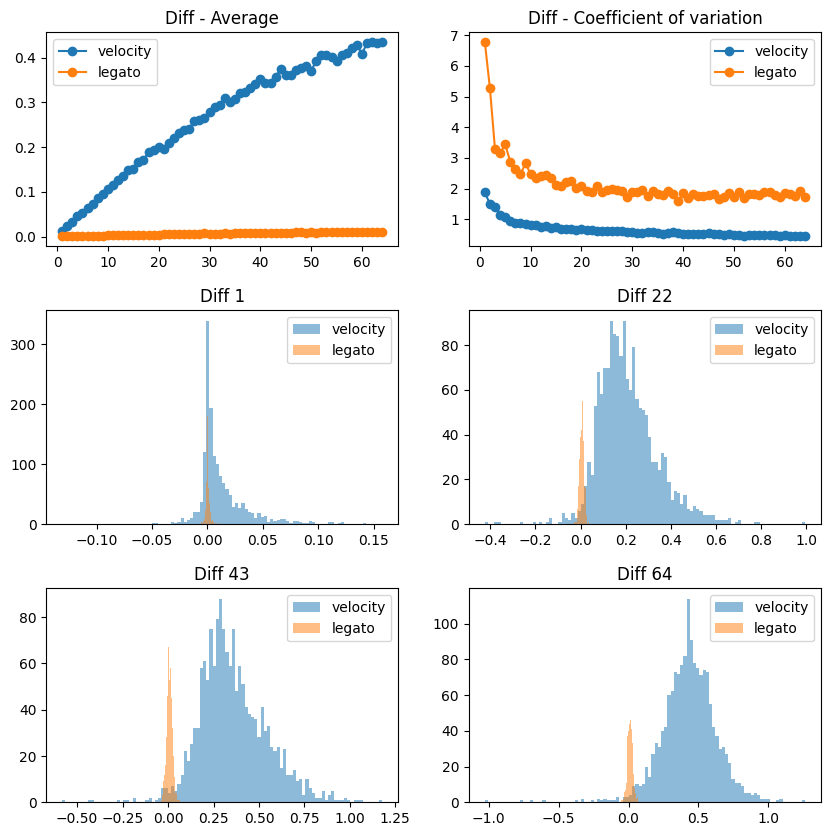

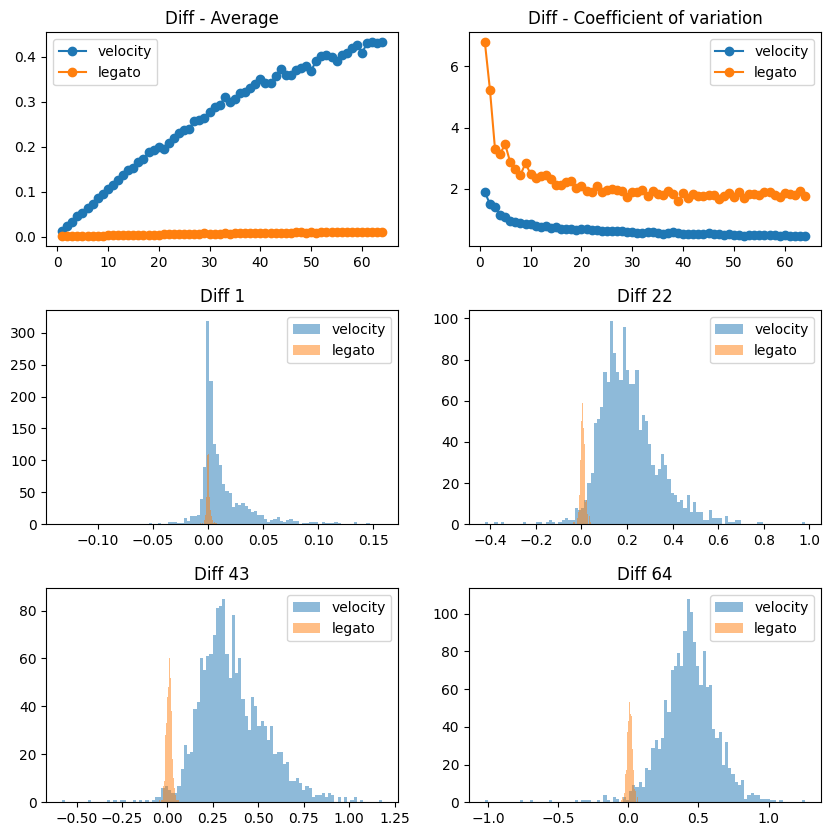

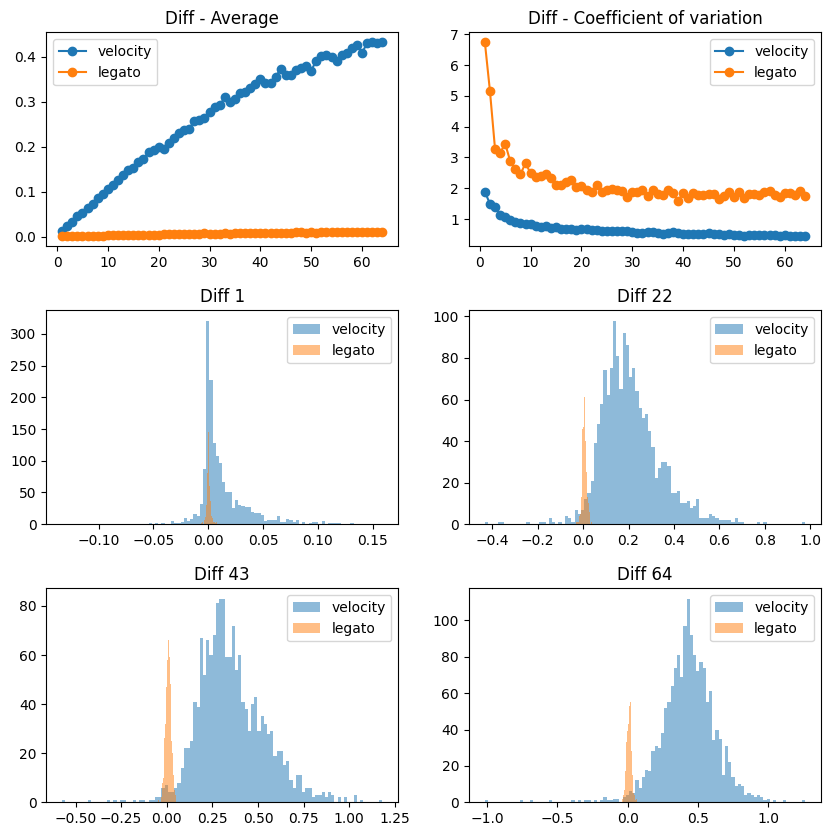

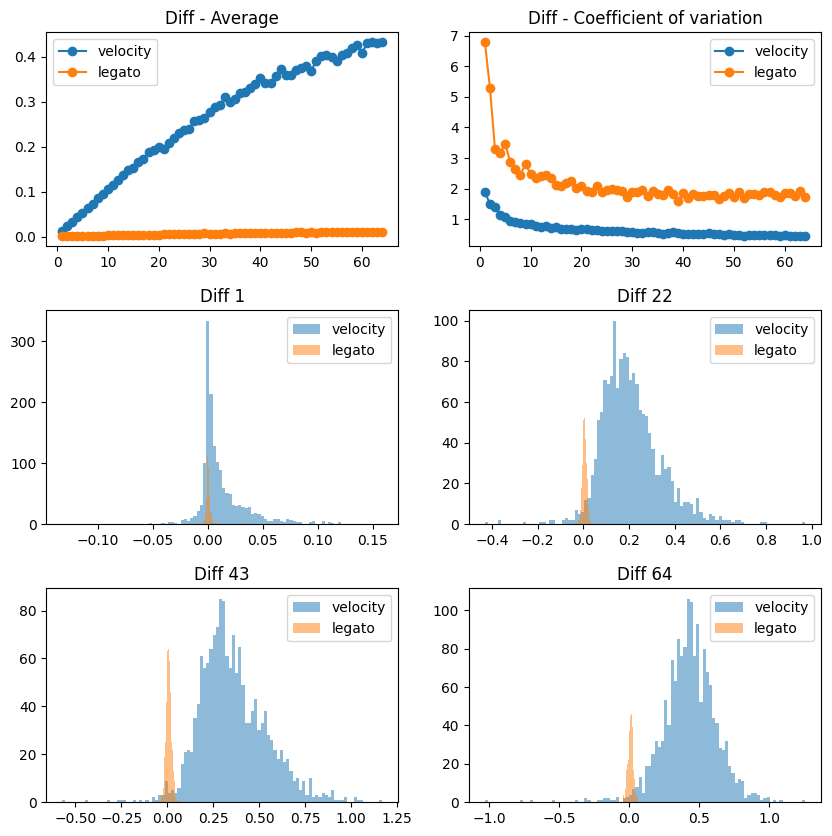

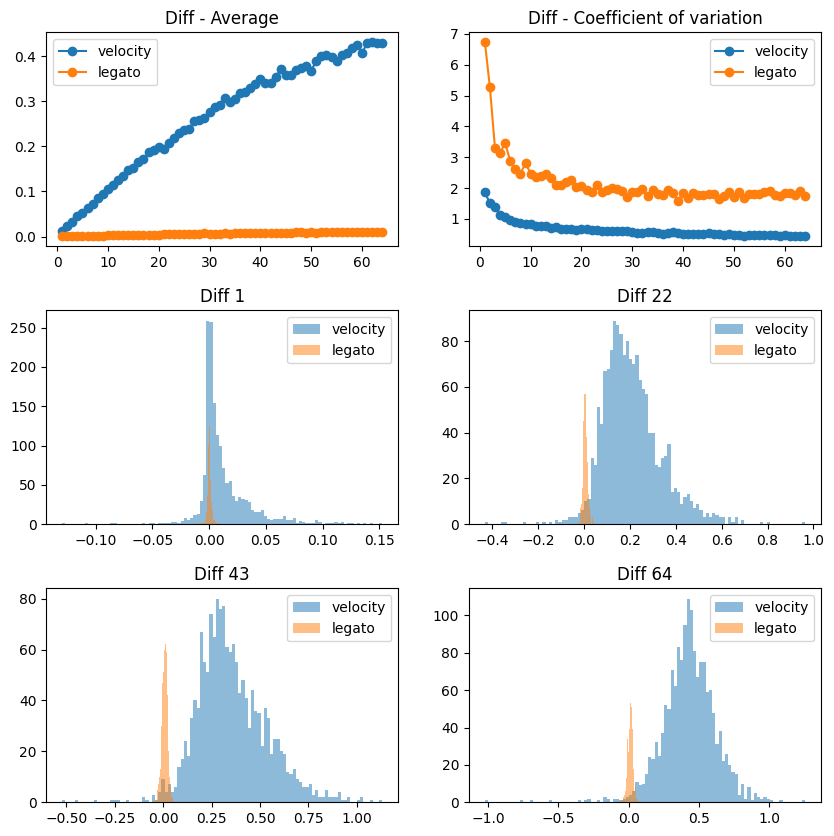

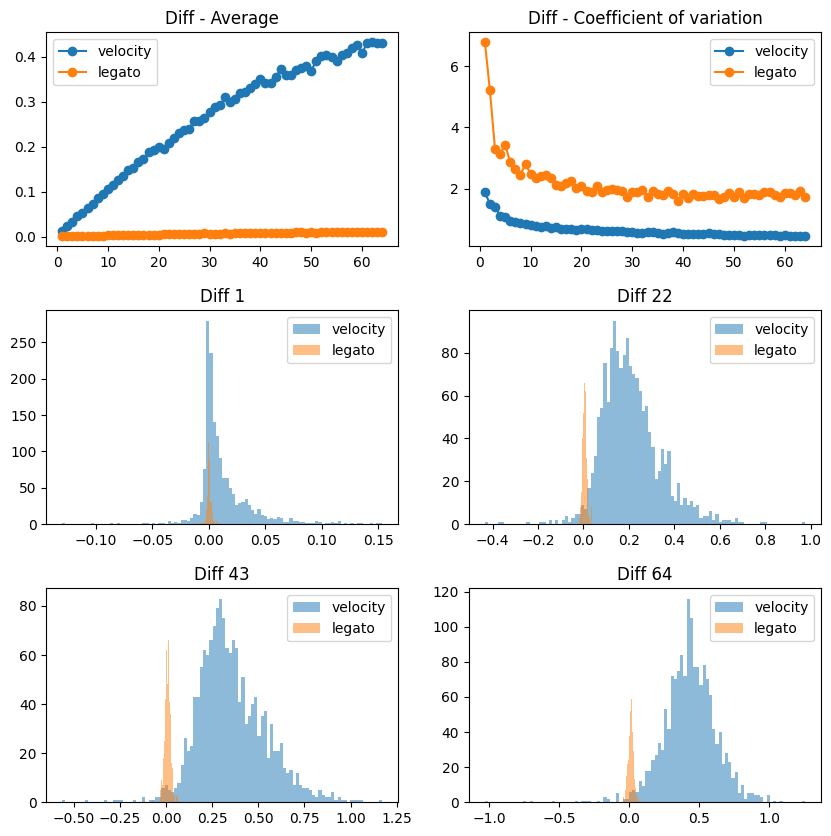

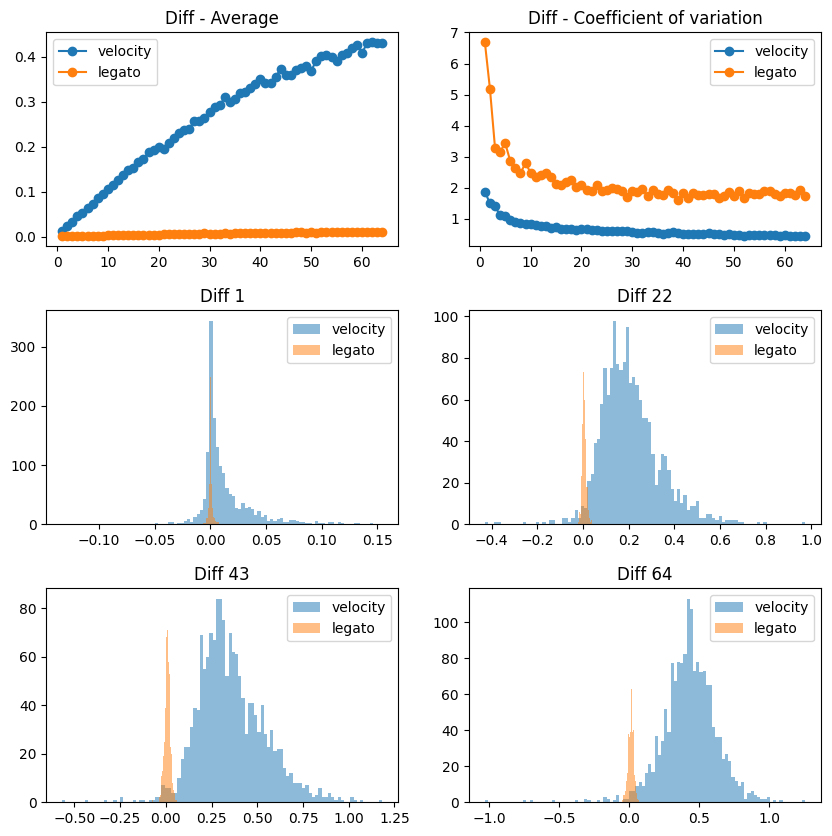

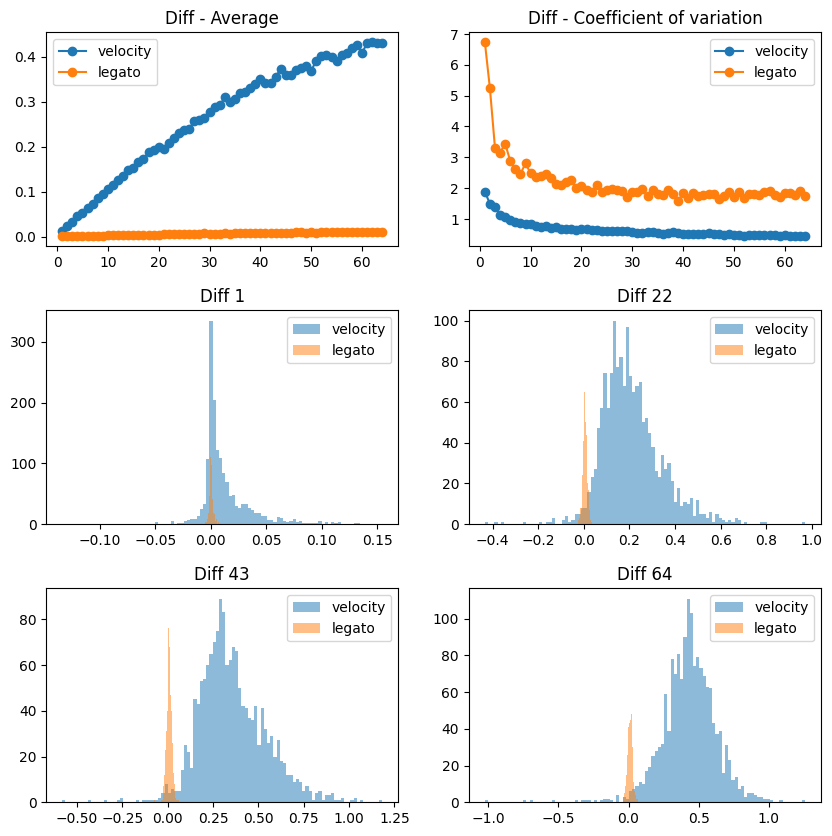

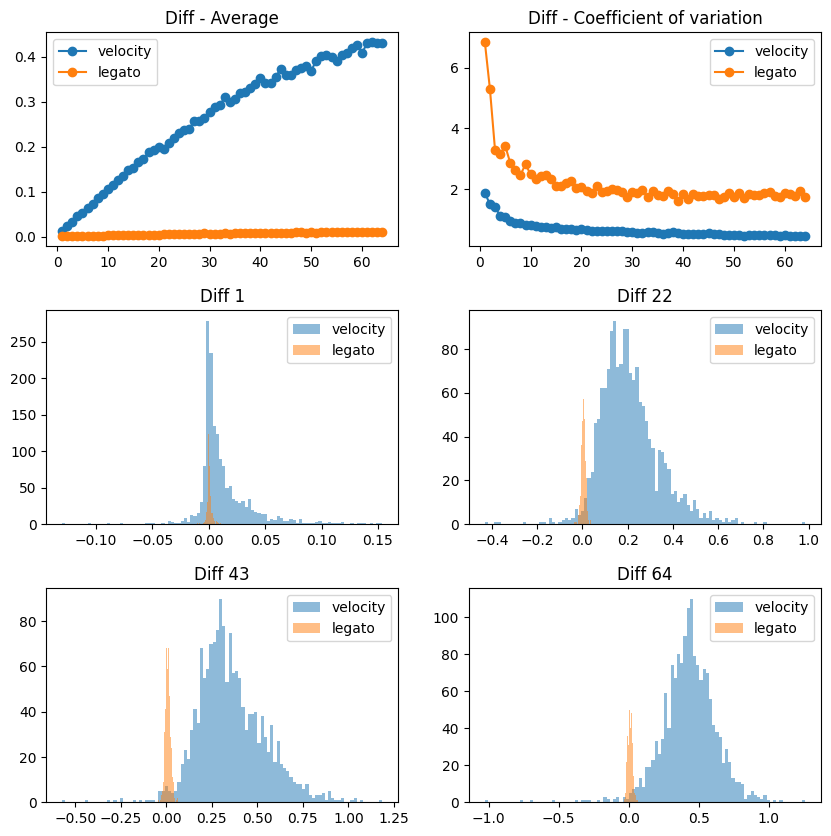

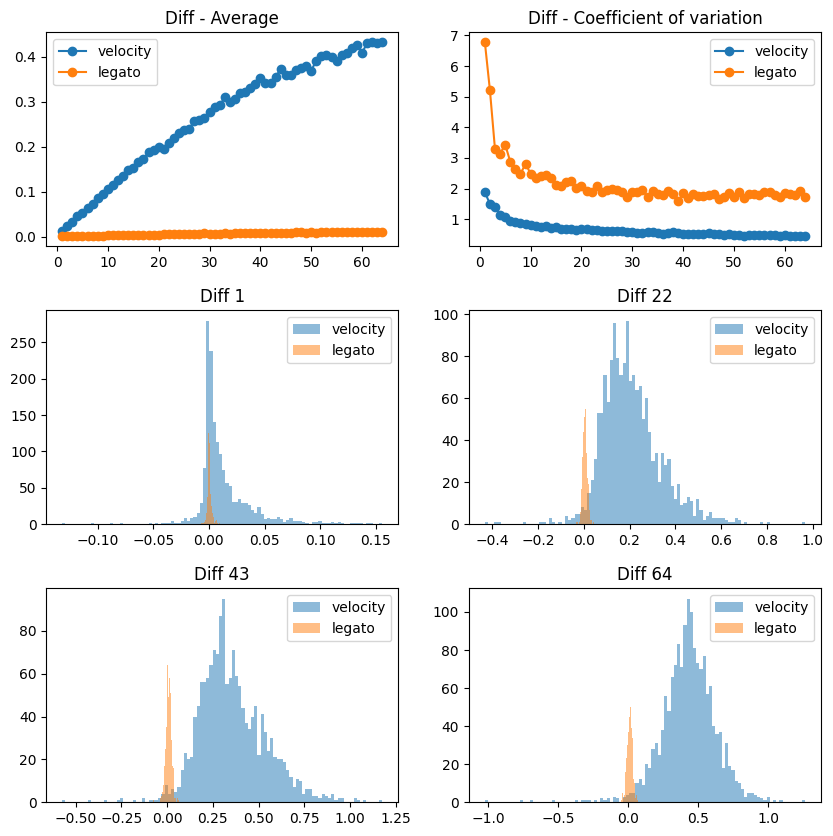

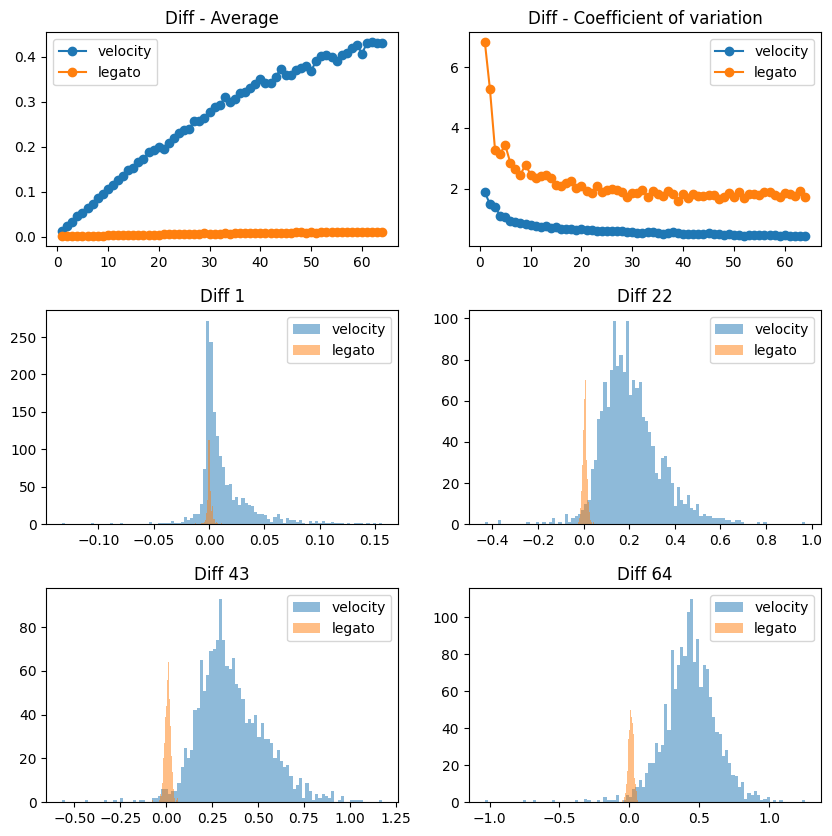

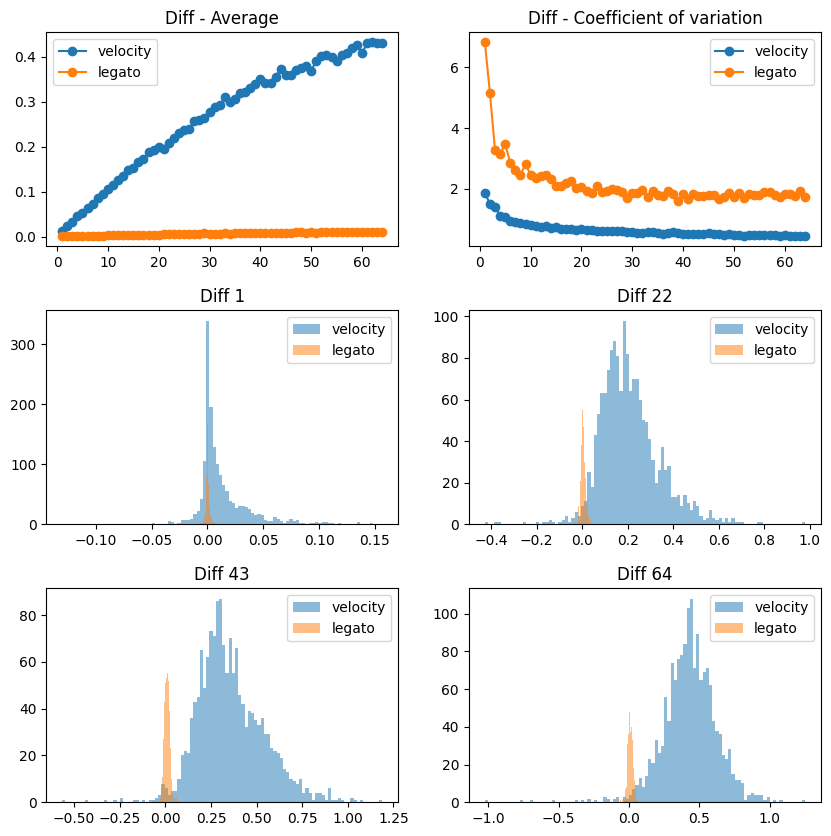

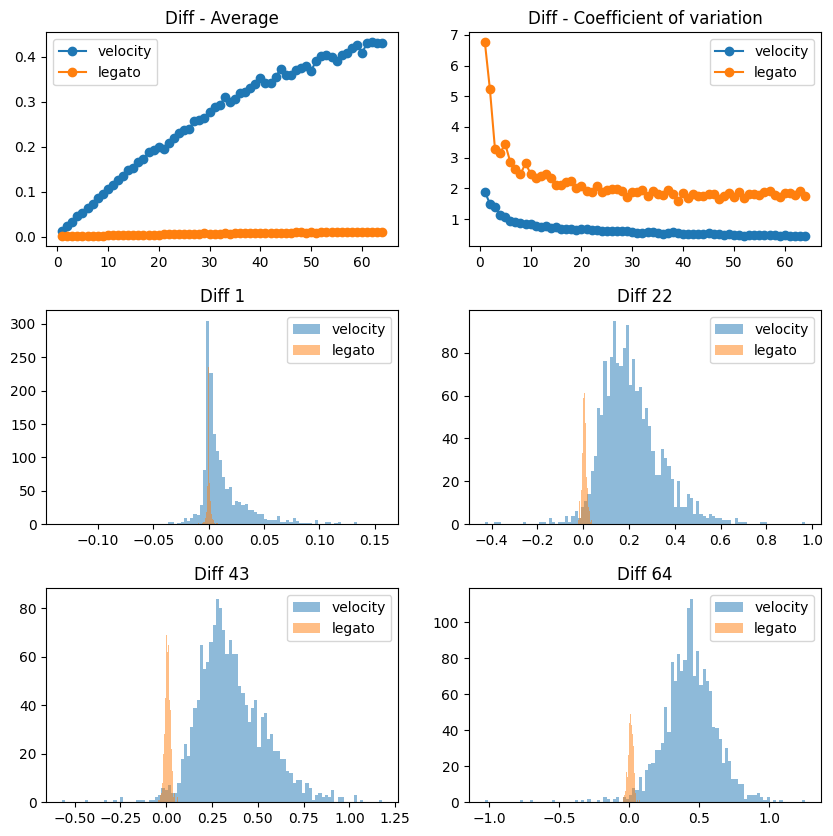

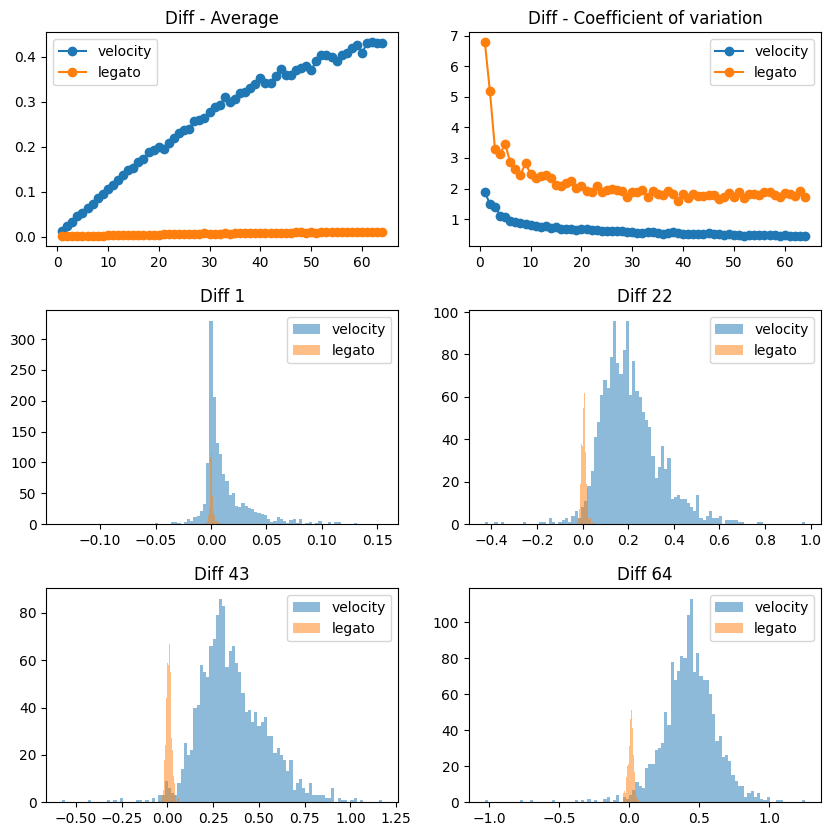

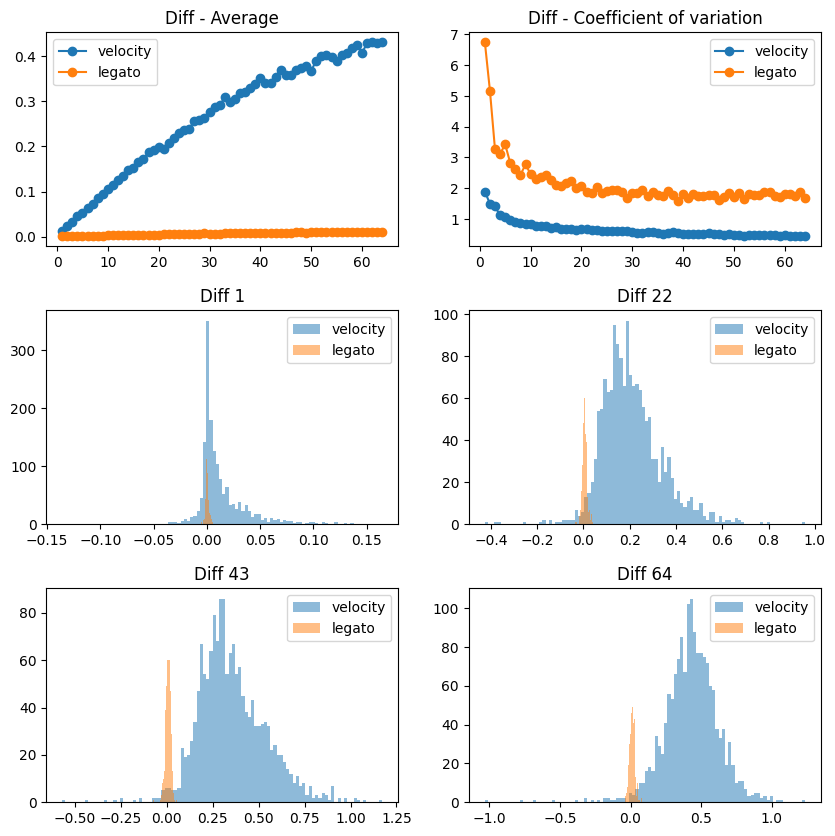

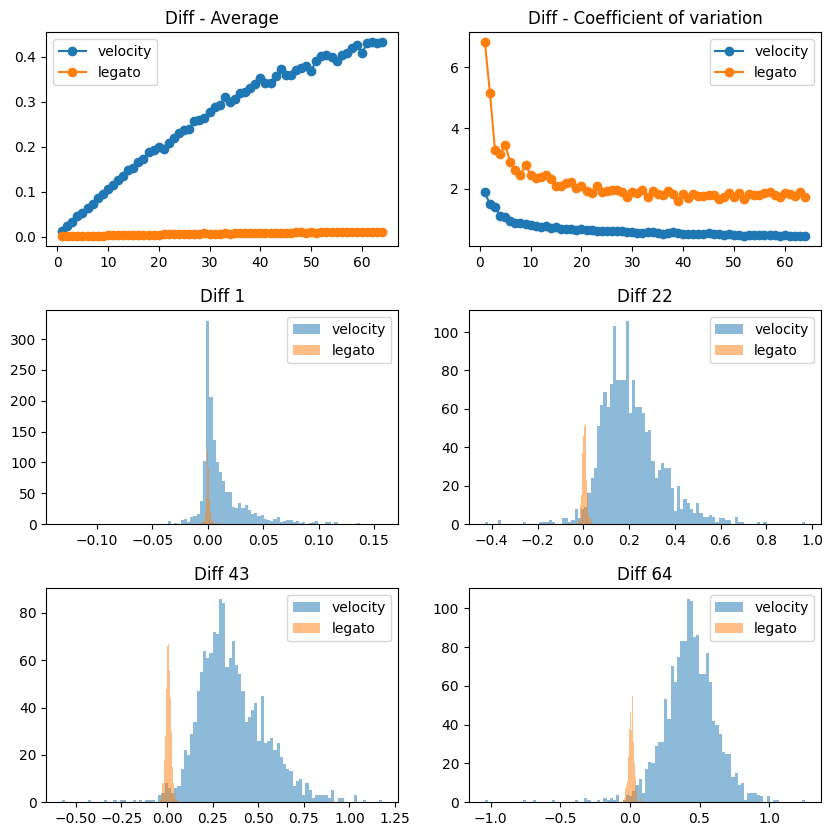

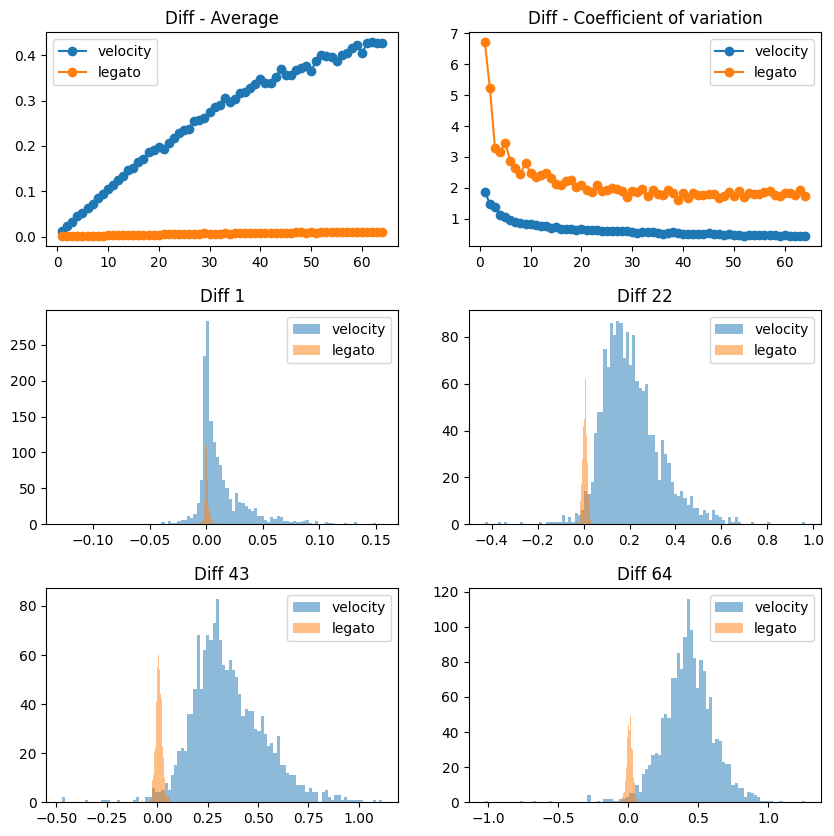

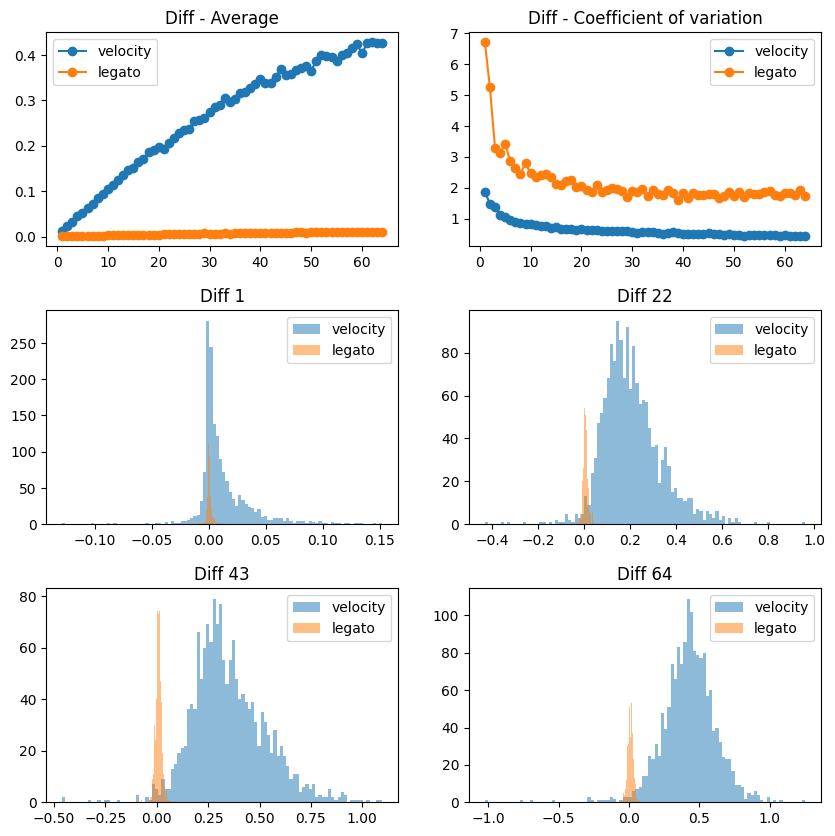

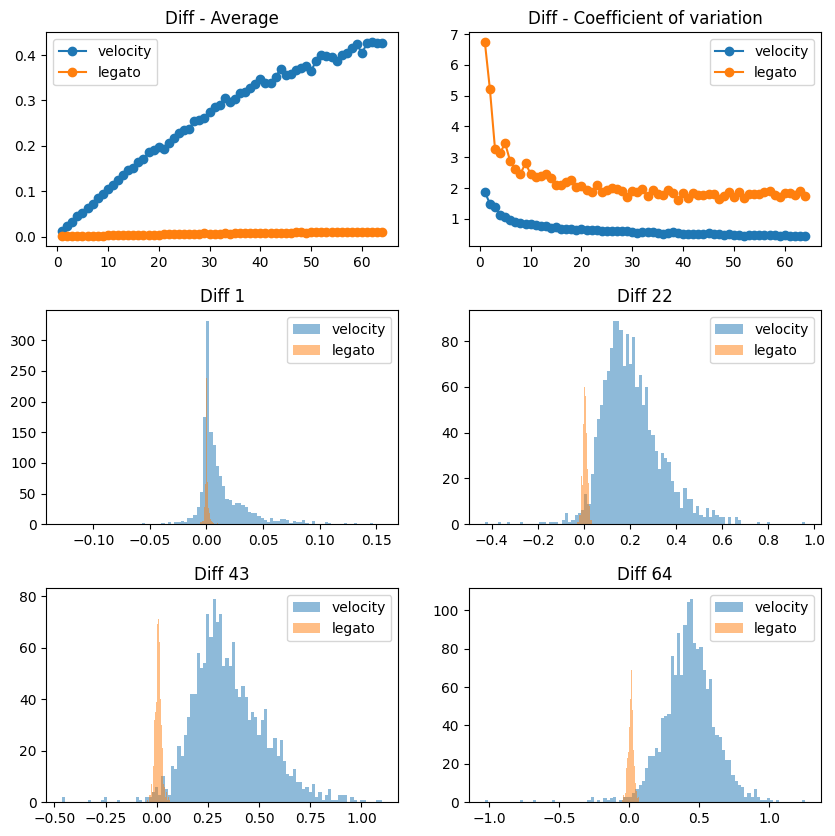

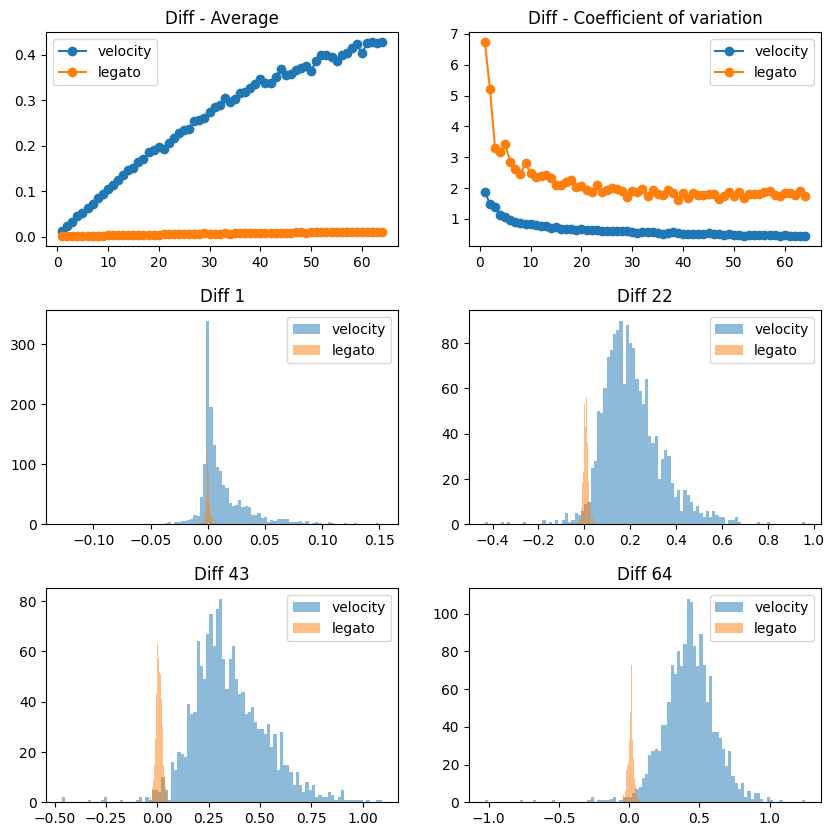

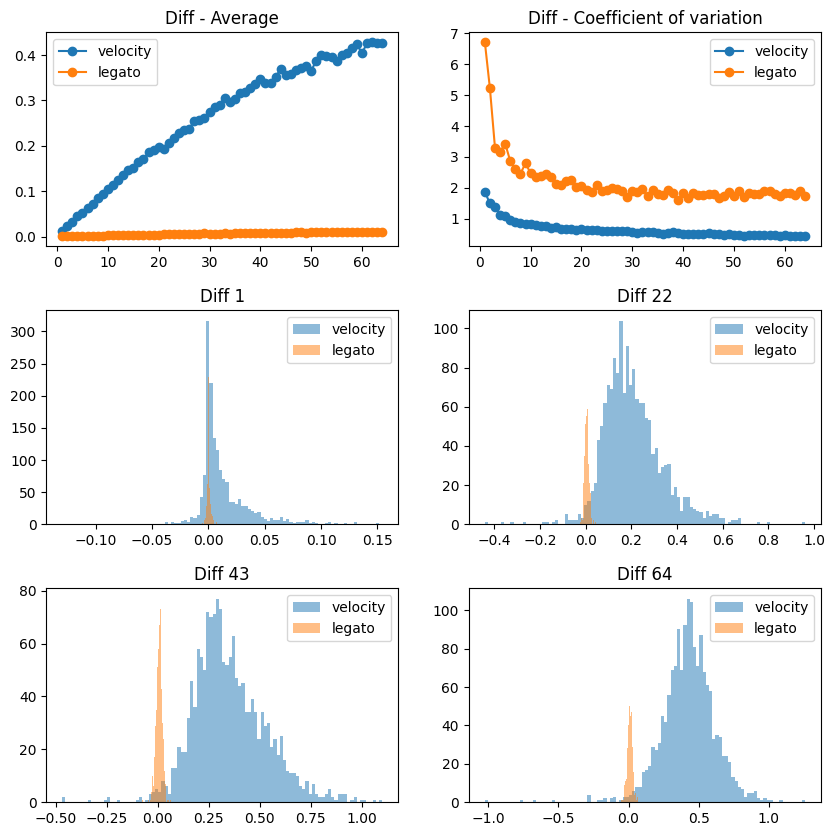

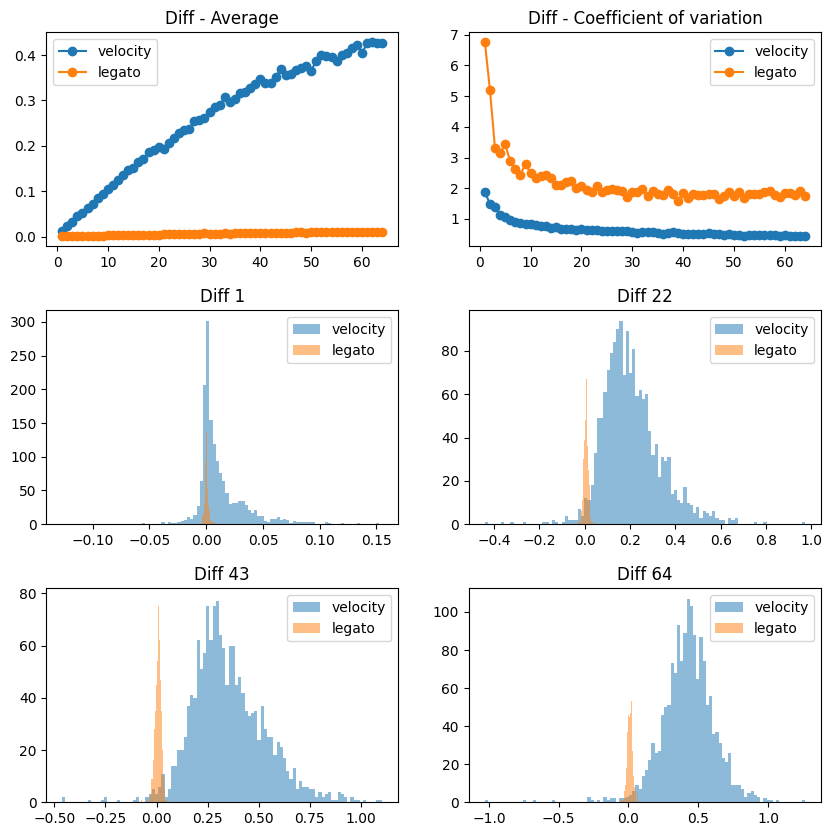

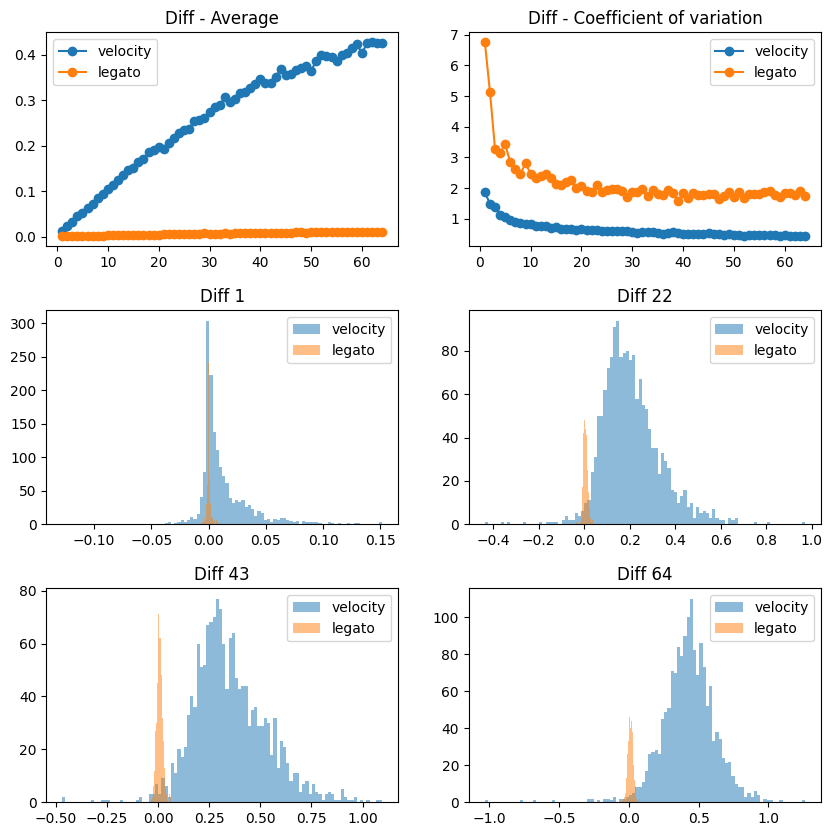

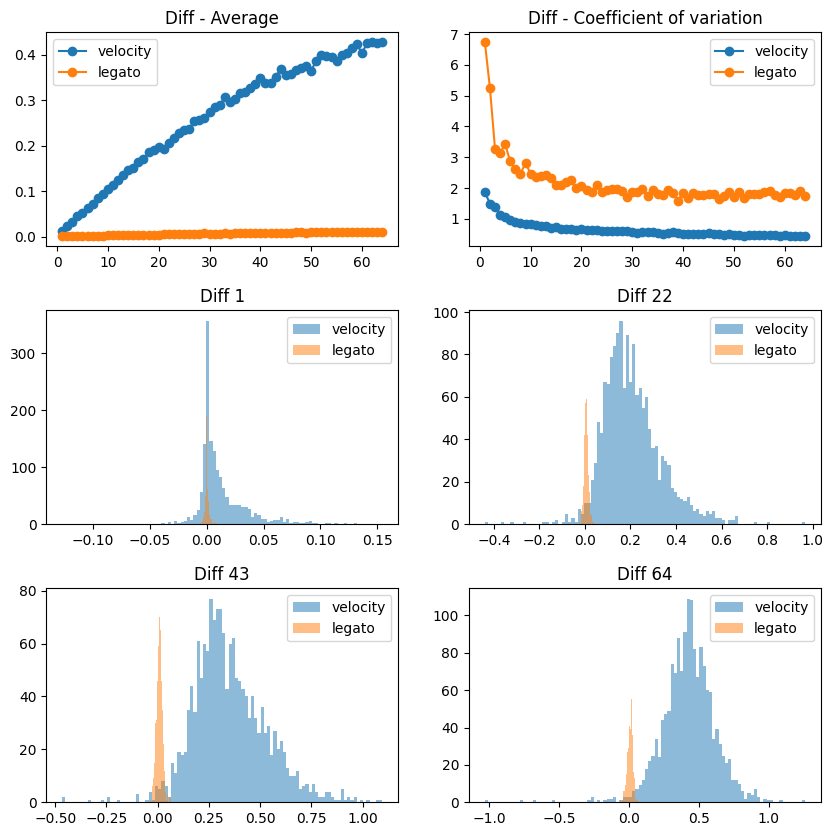

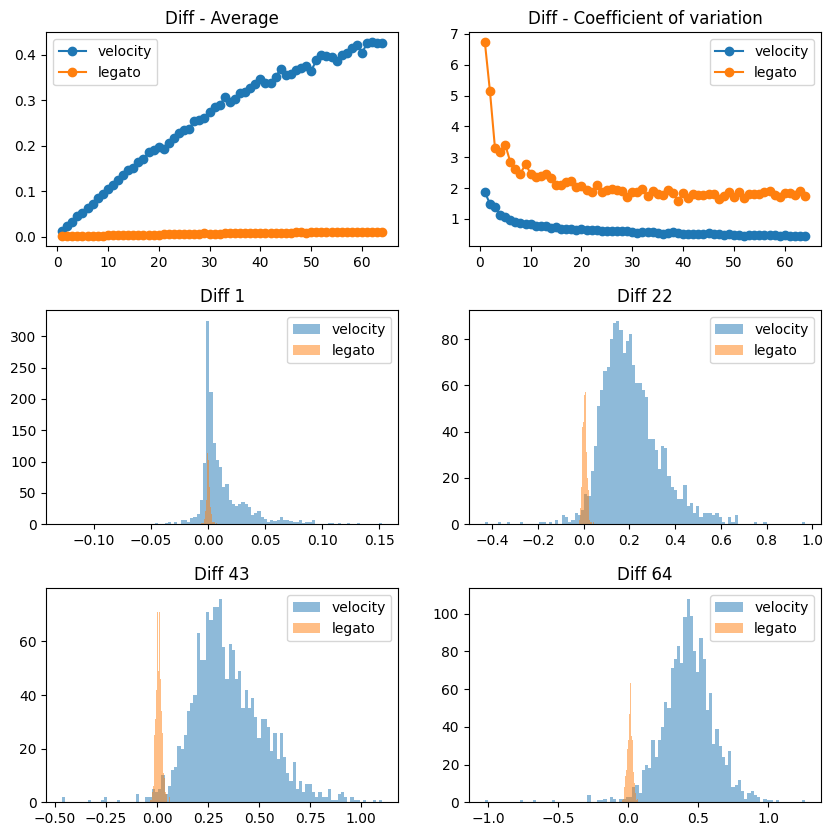

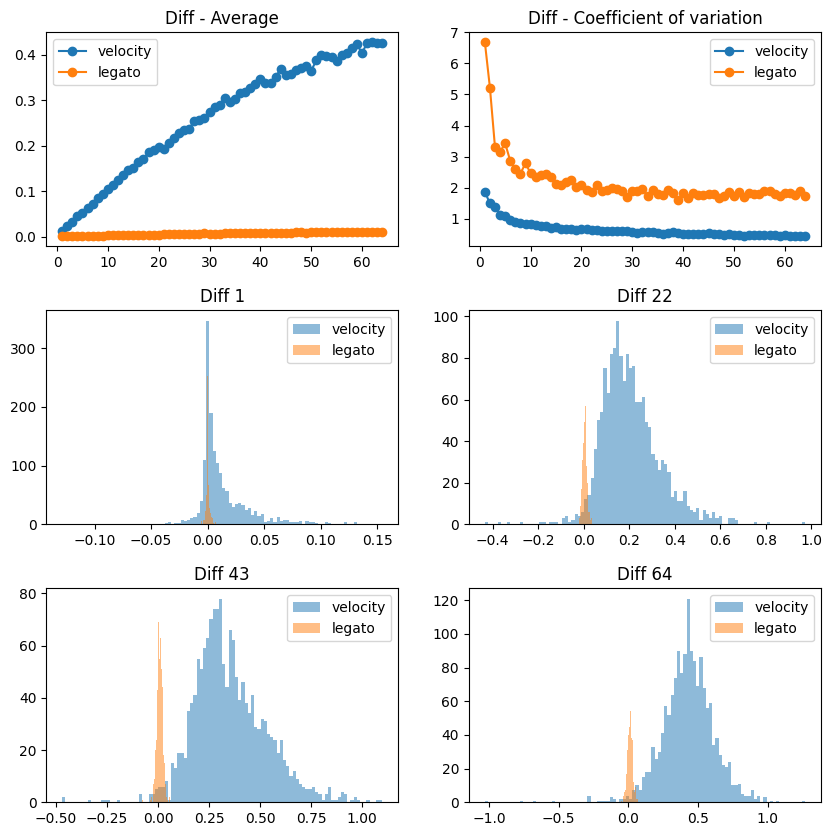

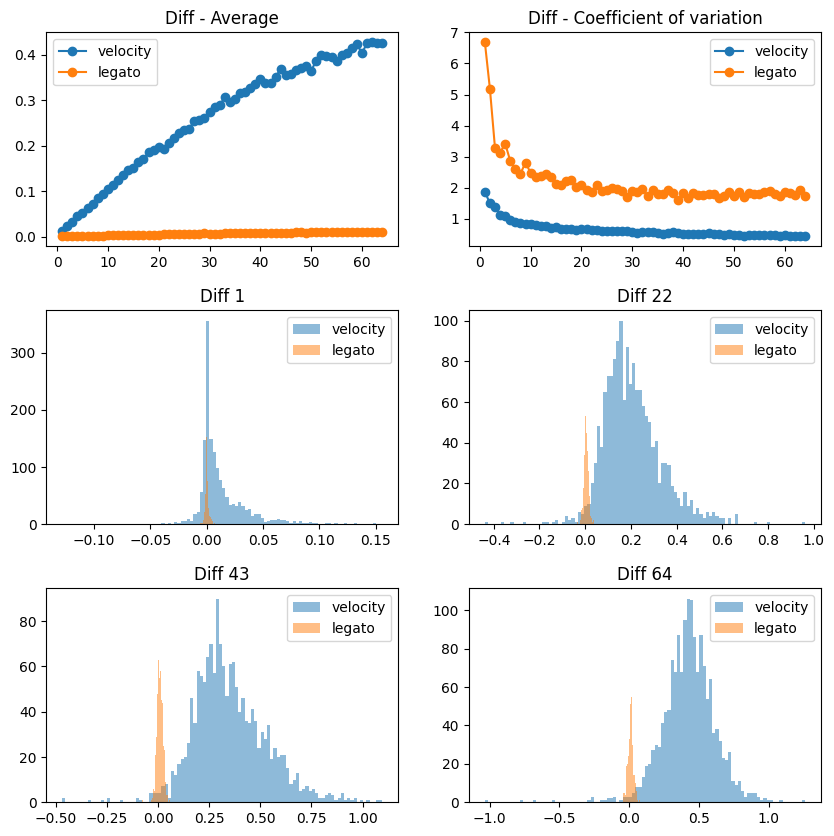

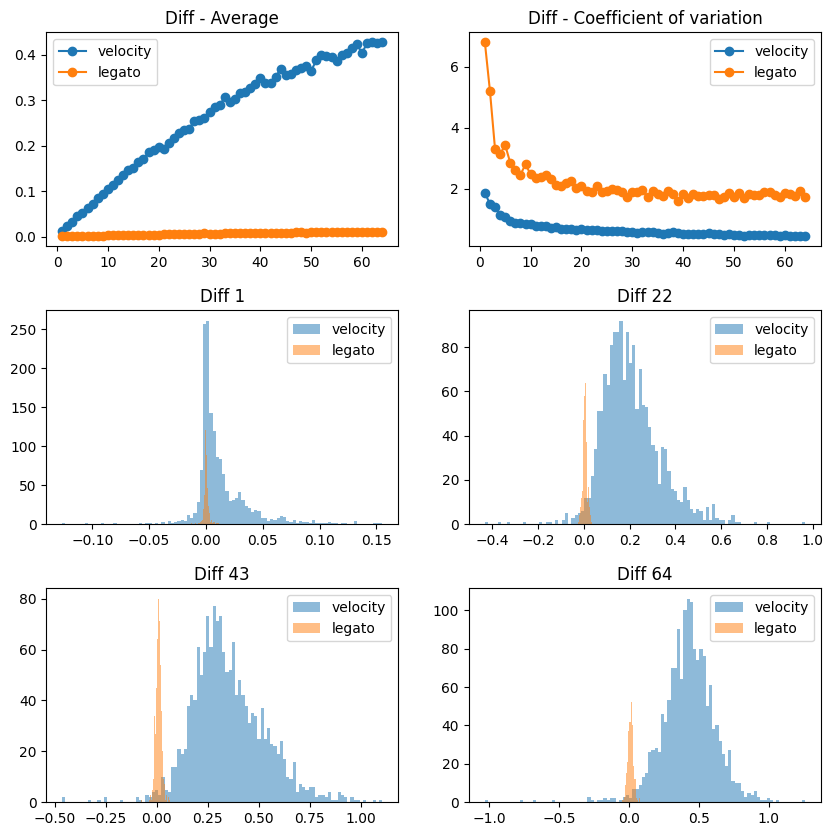

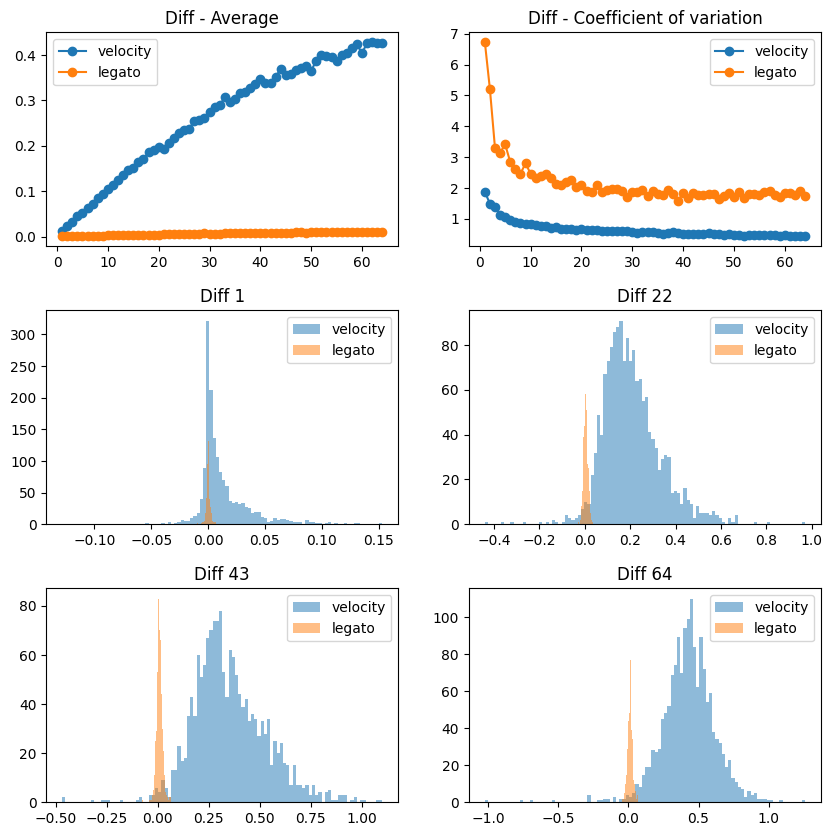

In [7]:
test(absolute_velocities[0], latent_dim[0], noise[2], architecture[3], f'0023', legw=1, epochs=40)